# Code Flow

### 1. Data preprocessing 
    * Voxel Morph model input을 맞추기 위한 과정

### 2. Voxel Morph Model build

### 3. Train

### 4. Inference step
    * Patch image reconstuction Step


---

In [3]:
# imports
import os, sys

# third party imports
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

# local imports
import voxelmorph as vxm
import neurite as ne
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
import numpy as np
import pandas as pd
import cv2 as cv
import glob
import os
from scipy import ndimage
from IPython import display 
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib
from ants import from_numpy, resample_image, registration, apply_transforms

gpus = tf.config.list_physical_devices('GPU')
print(gpus)
tf.config.set_visible_devices(gpus[3], 'GPU') # using GPU4



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


---
# Variable & Path


In [5]:
Moving_phase = 'D'
fixed_phase  = 'P'
patch_size = 64

train_base = '/media/monib/ext1/work2022/Base_Dataset/multi_phase_data/Orig/train/'
val_base   = '/media/monib/ext1/work2022/Base_Dataset/multi_phase_data/Orig/val/'

train_D_paths = glob.glob(train_base+f'/{Moving_phase}/*/*.nii')
train_P_paths = glob.glob(train_base+f'/{fixed_phase}/*/*.nii')
val_D_paths = glob.glob(val_base+f'/{Moving_phase}/*/*.nii')
val_P_paths = glob.glob(val_base+f'/{fixed_phase}/*/*.nii')

train_D_paths.sort()
train_P_paths.sort()
val_D_paths.sort()
val_P_paths.sort()


Train_num  = len(train_P_paths)
Val_num = len(val_P_paths)


---
# Utils function & Callback function

In [6]:
############################
# Result Analysis function #
############################

def get_2d_quiver(flow_2d, sp_factor = 20):
    """
    flow_2d: Flow filed in 2d+3 format. Example (512,512,3)
    sp_factor = sparsity factor.
    """
    spatial_flow = flow_2d[:, :, 0:2]
    meshg = meshgridnd_like(spatial_flow[::sp_factor, ::sp_factor, 0])
    mesh = np.asarray(meshg)
    mesh_mv = np.moveaxis(mesh, 0, -1)
    meshX = mesh_mv[:, :, 0]
    meshY = mesh_mv[:, :, 1]


    flowX_2d = flow_2d[::sp_factor, ::sp_factor, 0]
    flowY_2d = flow_2d[::sp_factor, ::sp_factor, 1]
    flowZ_2d = flow_2d[::sp_factor, ::sp_factor, 2]

    fig, ax = plt.subplots(figsize=(10,10))

    ax.quiver(meshX, meshY, flowX_2d, flowY_2d, flowZ_2d )
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect('equal')
    
    return fig

def meshgridnd_like(in_img, rng_func=range):
    new_shape = list(in_img.shape)
    all_range = [rng_func(i_len) for i_len in new_shape]
    return tuple([x_arr.swapaxes(0, 1) for x_arr in np.meshgrid(*all_range)])
def norm (array):
    array = (array-array.min())/(array.max() - array.min())
    return array


#######################
## Callback function ##
#######################

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()


def plot_learning_curve(log_df,
                        loss_name='loss',
                        loo_idx=None,
                        ylim=(None, None),
                        logscale=False,
                        **kwargs):
    """
    """
    print("loss name", loss_name)
    # Data from the log.csv
    epochs = np.arange(log_df.epoch.iloc[0] + 1, log_df.epoch.iloc[-1] + 2, 1, dtype=np.uint32)

    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=kwargs.get('fig_size', (9, 5)))

    if loo_idx is not None:
        plt.title(f'Learning Curves (Loss) (LOOCV: {loo_idx + 1})')
    else:
        plt.title(f'Learning Curves ({loss_name})')
    plt.xlabel('Epoch')  
    plt.ylabel('Loss')
    if logscale:
        plt.yscale('log')
        plt.grid(True, which='both')
    if ylim[0] is not None:
        plt.ylim(bottom=ylim[0])
    if ylim[1] is not None:
        plt.ylim(top=ylim[1])
    print("log_df loss name: ", log_df[f'{loss_name}'])
    plt.plot(epochs, log_df[f'{loss_name}'], '-', label='Training')
    # plt.plot(epochs, log_df[f'val_{loss_name}'], '-', label='Validation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.style.use('seaborn-white')
    
    
class LearningCurveCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        display.clear_output(wait=True)
        
        log_df = pd.read_csv(os.path.join(save_model_path, r'log_v2.csv'))
        display.display(log_df[-20:])
        plot_learning_curve(log_df, loss_name = 'vxm_dense_flow_loss')
        plot_learning_curve(log_df, loss_name = 'vxm_dense_transformer_loss')
        plot_learning_curve(log_df,loss_name='loss')
        
        display.display(plt.gcf())

---
# 1. Data Load & Preprocessing

In [7]:
# Train_num = 4
# Val_num = 1

In [8]:
T_moving = np.zeros((Train_num,512,512,192))
T_fixed  = np.zeros((Train_num,512,512,192))

# for i in tqdm(range(Train_num)):
#     moving   = nib.load(train_D_paths[i]).get_fdata()/10000
#     fixed    = nib.load(train_P_paths[i]).get_fdata()/10000   
#     T_moving[i,...,:moving.shape[-1]] = moving
#     T_fixed[i,...,:fixed.shape[-1]] = fixed

# print("Training Moving Data info")
# print(T_moving.shape)
# print(T_moving.min())
# print(T_moving.max())

# print("Training Fixed Data info")
# print(T_fixed.shape)
# print(T_fixed.min())
# print(T_fixed.max())


# V_moving = np.zeros((Val_num,512,512,192))
# V_fixed  = np.zeros((Val_num,512,512,192))

# for i in tqdm(range(Val_num)):
#     moving   = nib.load(val_D_paths[i]).get_fdata()/10000
#     fixed    = nib.load(val_P_paths[i]).get_fdata()/10000   
#     V_moving[i,...,:moving.shape[-1]] = moving
#     V_fixed[i,...,:fixed.shape[-1]] = fixed

# print("Val Moving Data info")
# print(V_moving.shape)
# print(V_moving.min())
# print(V_moving.max())

# print("Val Fixed Data info")
# print(V_fixed.shape)
# print(V_fixed.min())
# print(V_fixed.max())


---

# 2. Voxel Morph Model build & Compile 

* Use losses : Ncc loss(1), Gradient loss(0.01) 

In [9]:
vol_shape = (64, 64, 192)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

print(vxm_model.input)
print(vxm_model.output)

2022-07-19 11:04:34.613452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-19 11:04:35.199547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22010 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


[<KerasTensor: shape=(None, 64, 64, 192, 1) dtype=float32 (created by layer 'vxm_dense_source_input')>, <KerasTensor: shape=(None, 64, 64, 192, 1) dtype=float32 (created by layer 'vxm_dense_target_input')>]
[<KerasTensor: shape=(None, 64, 64, 192, 1) dtype=float32 (created by layer 'vxm_dense_transformer')>, <KerasTensor: shape=(None, 64, 64, 192, 3) dtype=float32 (created by layer 'vxm_dense_flow')>]


In [10]:
# Callback & weight save path
save_model_path = f'./model' 
checkpointer = callbacks.ModelCheckpoint(os.path.join(f'{save_model_path}','weights_{epoch:05d}_{loss:.4g}.h5'), save_weights_only=True)
csv_logger = callbacks.CSVLogger(f'{save_model_path}/log_v2.csv', append=True)
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=40)
plot_learning_curves_epoch = LearningCurveCallback()


# Loss
losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss]
lambda_param = 0.01
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

---

# 3. Model Train & Data generator

In [11]:
def make_patches(image, patch_size= 64):
    stride = int(patch_size)
    
    image_patches = []
    locations = []
    
    for subject_idx in range(image.shape[0]):
        for i in range(0, image.shape[1], stride):
            for j in range(0, image.shape[2], stride):
                Patch = np.zeros((patch_size,patch_size,192))
                Patch[Patch==0]= -1024/10000
                img_patch = image[subject_idx,i:i + patch_size,j:j + patch_size, :]
    
                Patch[: img_patch.shape[0],:img_patch.shape[1],:] = img_patch
                
                patch_img = Patch
                image_patches.append(patch_img)
                locations.append((subject_idx,i, j))
                
    patch_array = np.zeros((len(image_patches),patch_size,patch_size,image.shape[-1]))
    for idx in range(len(image_patches)):
        patch_array[idx,:,:,:] = image_patches[idx]
    return patch_array, locations

In [16]:
patch_save_path = f'./patch_data_{Moving_phase}_{fixed_phase}_{patch_size}'

# try:
#     os.makedirs(patch_save_path)
# except FileExistsError as err:
#     print(err)
# else:
#     print(patch_save_path)
    
# """
# FIXME: Double check this part
# """
patch_number = int((512/patch_size)*(512/patch_size))

# print(T_moving.shape) 
# for i in tqdm(range(Train_num)):
#     print(T_moving[i:i+1].shape)
#     moving_patches , _ = make_patches(T_moving[i:i+1],patch_size)
#     fixed_patches  , _ = make_patches(T_fixed[i:i+1],patch_size)
#     print("moving_P", moving_patches.shape)
    

#     for j in range(patch_number):
#         moving = moving_patches[j:j+1]
#         fixed = fixed_patches[j:j+1]
#         np.savez(f'./patch_data_{Moving_phase}_{fixed_phase}_{patch_size}/{i*patch_number+j}.npz',moving =moving,fixed=fixed)

In [21]:
def vxm_data_generator(data_number = 75*64, batch_size=128):
    
    
    while True:
        
        idx1 = np.random.randint(0, data_number, size=batch_size)
        
        data = np.load(f'./patch_data_{Moving_phase}_{fixed_phase}_{patch_size}/{idx1[0]}.npz')

        moving_images = data['moving']
        fixed_images  = data['fixed']

        zero_phi = np.zeros([batch_size,*fixed_images.shape[1:4]])
        # print("mv shape", moving_images.shape)
        # print("fix shape", fixed_images.shape)
        # print("phi shape", zero_phi.shape)
        

        inputs = [moving_images, fixed_images]

        outputs = [fixed_images, zero_phi]

        yield inputs, outputs

In [24]:
train_gen = vxm_data_generator(Train_num,patch_number)
inputs, outputs = next(train_gen)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs[0].shape)
print(outputs[1].shape)

(1, 64, 64, 192)
(1, 64, 64, 192)
(1, 64, 64, 192)
(64, 64, 64, 192)


,epoch,loss,vxm_dense_flow_loss,vxm_dense_transformer_loss
0,0,-0.883487,3.441727e-07,-0.883487
1,1,-0.863003,2.456713e-05,-0.863003
2,2,-0.802453,2.409862e-04,-0.802455


loss name vxm_dense_flow_loss
log_df loss name:  0    3.441727e-07
1    2.456713e-05
2    2.409862e-04
Name: vxm_dense_flow_loss, dtype: float64


<Figure size 432x288 with 0 Axes>

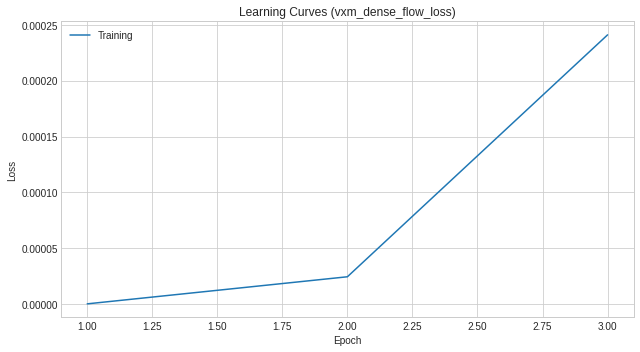

loss name vxm_dense_transformer_loss
log_df loss name:  0   -0.883487
1   -0.863003
2   -0.802455
Name: vxm_dense_transformer_loss, dtype: float64


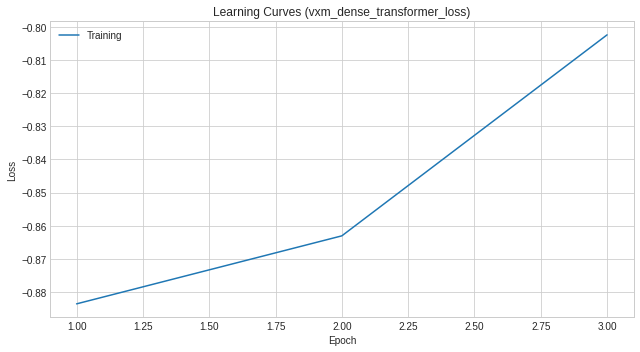

loss name loss
log_df loss name:  0   -0.883487
1   -0.863003
2   -0.802453
Name: loss, dtype: float64


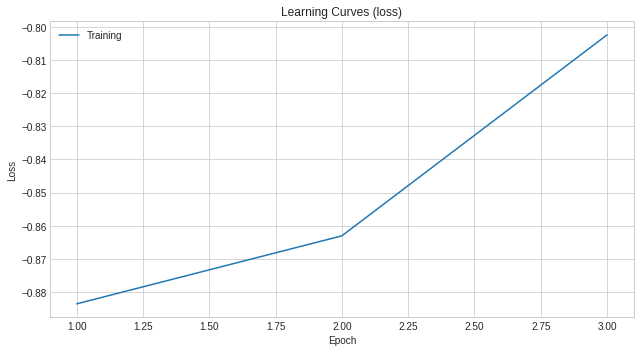

<Figure size 432x288 with 0 Axes>

10/10 [==============================] - 2s 226ms/step - loss: -0.8025 - vxm_dense_transformer_loss: -0.8025 - vxm_dense_flow_loss: 2.4099e-04


<Figure size 432x288 with 0 Axes>

In [19]:
with tf.device('GPU:3'):

    hist = vxm_model.fit(train_gen,
                         steps_per_epoch = 10,
                         
                         epochs=3,
                         callbacks=[checkpointer, 
                                    csv_logger,
                                    # early_stopping,
                                    plot_learning_curves_epoch
                                   ],
                         
                        )
    

---

# 4. Inference Step & Image reconstruction


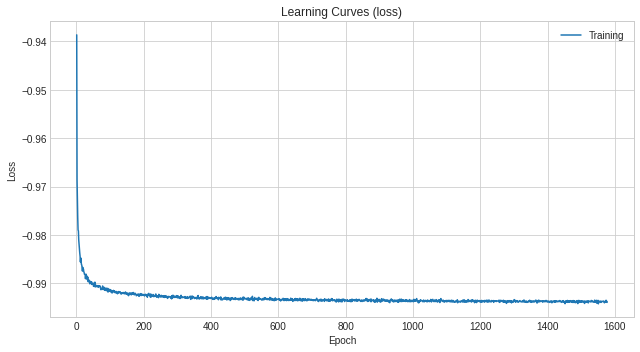

AttributeError: 'DataFrame' object has no attribute 'val_loss'

In [15]:
log_df = pd.read_csv(os.path.join(save_model_path, r'log.csv'))
plot_learning_curve(log_df)
display.display(log_df.iloc[[log_df.val_loss.idxmin()]])

In [31]:
# best_epoch = log_df.loss.idxmin()
# print(best_epoch)
vxm_model.load_weights(glob.glob(os.path.join(save_model_path, "weights_01577_-0.994.h5"))[0])


In [32]:
val_subject_num = 1

In [33]:
moving_patches , location_A = make_patches(V_moving[val_subject_num:val_subject_num+1],patch_size)
fixed_patches  , location_A = make_patches(V_fixed[val_subject_num:val_subject_num+1] ,patch_size)
                                                 

In [34]:
with tf.device('GPU:0'):
    val_pred = vxm_model.predict([moving_patches,fixed_patches]);

In [35]:
recon_image = np.zeros((512,512,192))
for loc_idx in range(len(location_A)):
    a_coor_A, b_coor_A = location_A[loc_idx][1] , location_A[loc_idx][2]  
    recon_image[a_coor_A:a_coor_A+patch_size,
                b_coor_A:b_coor_A+patch_size,...]= val_pred[0][loc_idx][...,0]
    
recon_image = np.swapaxes(recon_image[:512,:512,:],0,1)*10000
# recon_image =recon_image[:512,:512,:]*10000

print(recon_image.shape)
print(recon_image.max())
print(recon_image.min())

(512, 512, 192)
1588.2857143878937
-1024.000197649002


In [39]:
slice_number = 40
moving = np.swapaxes(V_moving[val_subject_num][...,slice_number],0,1)*10000
fixed = np.swapaxes(V_fixed[val_subject_num][...,slice_number],0,1)*10000
predict = recon_image[:,:,slice_number]

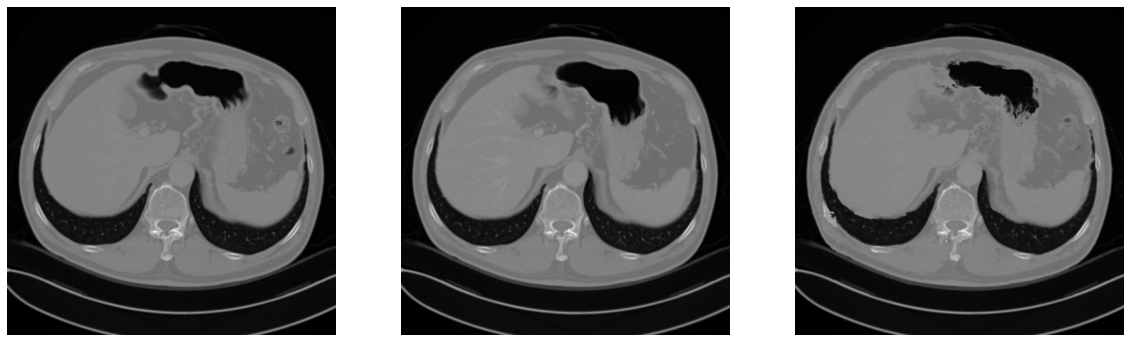

In [40]:
plt.figure(figsize= (20,40))
plt.subplot(1, 3, 1).axis('off')       
plt.imshow(moving,cmap='gray')

plt.subplot(1, 3, 2).axis('off')    
plt.imshow(fixed ,cmap='gray')
plt.subplot(1, 3, 3).axis('off')
plt.imshow(predict ,cmap='gray')
plt.show()

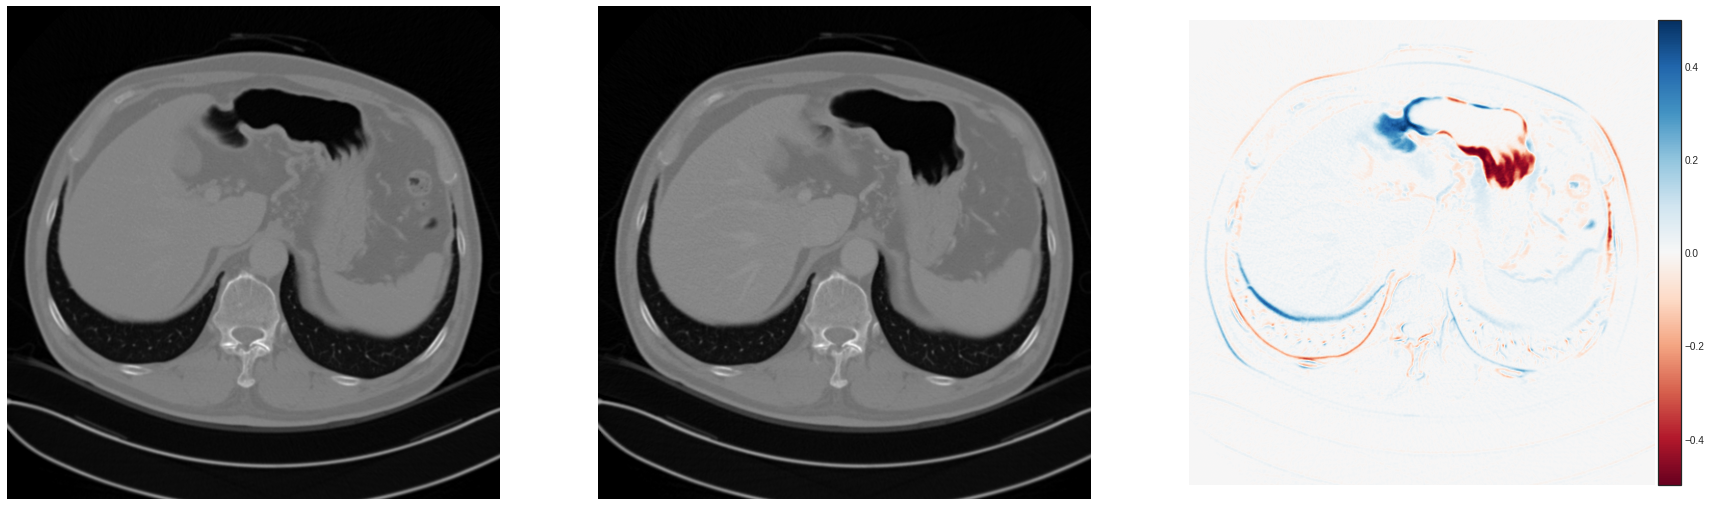

In [41]:


from mpl_toolkits.axes_grid1 import make_axes_locatable


fig , (ax1,ax2,ax3) =plt.subplots(1, 3,figsize=(30,30))


z1_plot = ax1.imshow(moving,cmap='gray')
ax1.axis("off")

z2_plot = ax2.imshow(fixed ,cmap='gray')
ax2.axis("off")

z3_plot = ax3.imshow((norm(fixed) - norm(moving)),cmap='RdBu' ,vmin =- 0.5, vmax = 0.5 )
ax3.axis("off")
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(z3_plot, cax=cax)

plt.show()

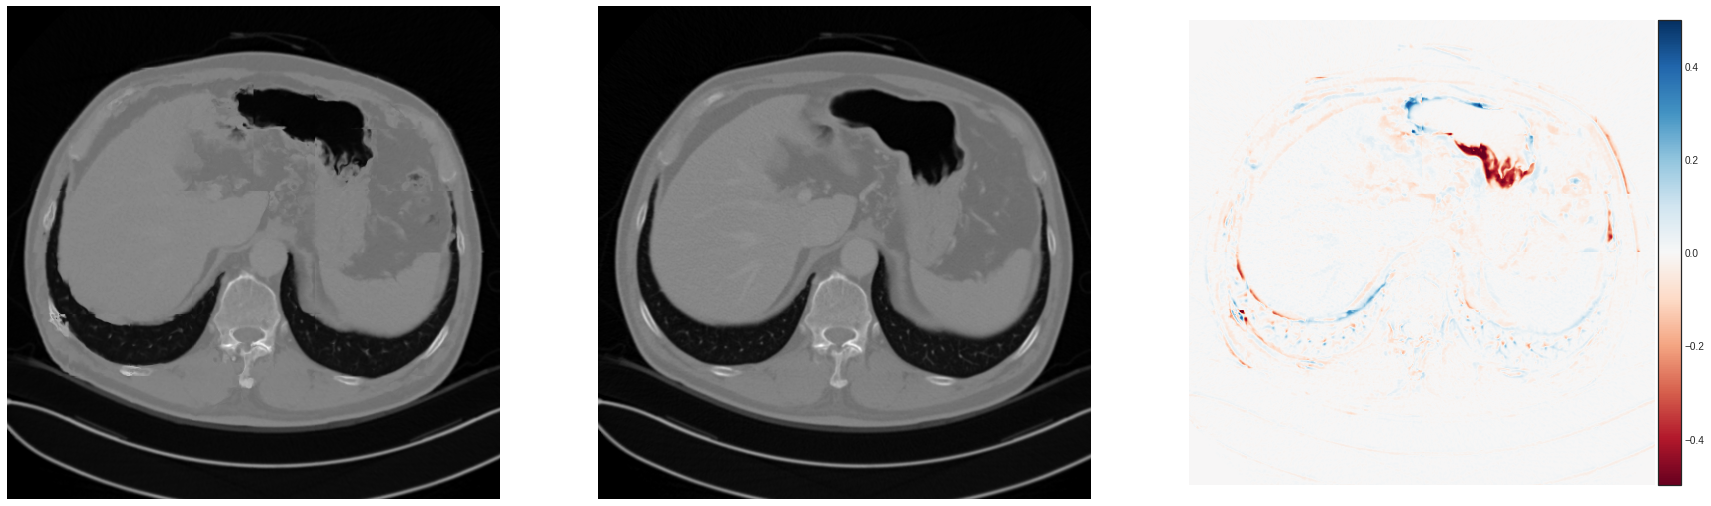

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig , (ax1,ax2,ax3) =plt.subplots(1, 3,figsize=(30,30))


z1_plot = ax1.imshow(predict,cmap='gray')
ax1.axis("off")

z2_plot = ax2.imshow(fixed ,cmap='gray')
ax2.axis("off")

z3_plot = ax3.imshow((norm(fixed) - norm(predict)),cmap='RdBu' ,vmin =- 0.5, vmax = 0.5 )
ax3.axis("off")
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(z3_plot, cax=cax)

plt.show()

---

# 5. Prediction Data Save & Result analysis

In [43]:
nii_input = nib.load(val_D_paths[val_subject_num])
header = nii_input.header
new_image = nib.Nifti1Image(moving_data[val_subject_num],nii_input.affine, header)
nib.save(new_image,'moving_HCC_1765_D.nii')

NameError: name 'moving_data' is not defined

In [ ]:
nii_input = nib.load(val_P_paths[val_subject_num])
header = nii_input.header
new_image = nib.Nifti1Image(fixed_data[val_subject_num],nii_input.affine, header)
nib.save(new_image,'fixed_HCC_1765_P.nii')

In [ ]:
recon_image = np.zeros((512,512,192))
for loc_idx in range(len(location_A)):
    a_coor_A, b_coor_A = location_A[loc_idx][1] , location_A[loc_idx][2]  
    recon_image[a_coor_A:a_coor_A+patch_size,
                b_coor_A:b_coor_A+patch_size,...]= val_pred[0][loc_idx][...,0]
    
# recon_image = np.swapaxes(recon_image[:512,:512,:],0,1)*10000
recon_image =recon_image[:512,:512,:]*10000

print(recon_image.shape)
print(recon_image.max())
print(recon_image.min())

In [ ]:
nii_input = nib.load(val_D_paths[val_subject_num])
z_slice = nii_input.get_fdata()
header = nii_input.header
new_image = nib.Nifti1Image(recon_image,nii_input.affine, header)
nib.save(new_image,'moved_HCC_1469_D.nii')